# <div align="center">TVLA<div>



In [19]:
# import libraries
import os
import sys
import shutil
import json
import foboslib.pynqctrl
from foboslib.fobosctrl import FOBOSCtrl
import foboslib.projmgr
import numpy as np
from foboslib.picoscope import Picoscope
from foboslib.tvlaCalc import TVLACalc
#######################################################
# acquisition configuration
# connection to ctrl board
acqConf = {}
acqConf['ip'] = '192.168.10.99'
acqConf['port'] = 9995
# File names and locations
acqConf['workspace'] = "." # Folder to store projects
acqConf['projectName'] = "xoodyak-dom"      # Name of this project. Files will be in WORKSPACE/PROJECT_NAME/
acqConf['dinFile'] = "dinFile.txt"      # test vectors in FOBOS format incl. plaintext and key
acqConf['cipherFile'] = "doutFile.txt"     # observed ciphertext, result from applying test vectors
acqConf['fvrFile'] = "fvrchoicefile.txt"
acqConf['traceFile']  = "powerTraces.npy"     # Name of file for recording power traces

In [20]:
#Acquistion configuration
acqConf['traceNum'] = 10000000            # number of traces to run [default: 10]
acqConf['DUTClk'] = 10 * 1.6         # clock frequency of the DUT in MHz, [range: 1 - 100]
acqConf['samplingFreq'] =  50 * 1.6  # sampling frequency of the Oscilloscope in Msps [default: 50][range: 1 - 100]
# tinyjambu-dom needs 615 cc for the current tv
acqConf['samplesPerTrace'] = 5 * 80 # number of sample in one trace [range: 1 - 2^17]
acqConf['ADCGain'] = 30              # amplification of ADC input signal [default: 40][range: 0 - 60]
acqConf['outLen'] = 88               # output length for current test vector


In [21]:
# Configure project directories
pm = foboslib.projmgr.ProjectManager()
pm.setWorkSpaceDir(acqConf['workspace'])
pm.setProjName(acqConf['projectName'])
projDir = pm.getProjDir()

Acquired hardware lock
008203e80084667700854455008622330087aa1100800002
aa aa aa aa
Successfully created new capture directory at ./xoodyak-dom/capture/attempt-06
# Acquisition parameters:
DUT_CLK = 16.0
OUT_LEN = 88
SAMPLING_FREQ = 80
ADC_GAIN = 30
SAMPLES_PER_TRACE = 400

Processing test vectors ...


/home/bakry/projects/GMU/Xoodyak-384-DOM/sca_verif/foboslib/tvlaCalc.py:67: RuntimeWarning: invalid value encountered in true_divide
  return self.CS2_0 / self.n_0


Data acquisition complete.
Released hardware lock.


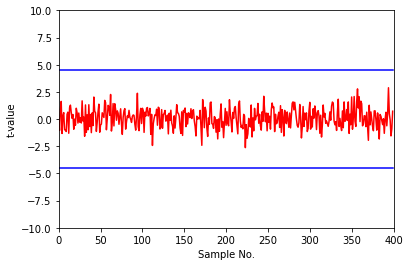

In [22]:
# connect to hardware and lock it ######################################
ctrl = foboslib.pynqctrl.PYNQCtrl(acqConf['ip'], acqConf['port'])
# Apply config to ctrl board ###########################################
try:
    ctrl.setDUTClk(acqConf['DUTClk'])
    ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)
    ## configure DUT PRNG
    #ctrl.setOutLen(4)
    seed = 0xaa11223344556677
    num_rand_words = 1000
    ctrl.confPrng(seed, num_rand_words)
    ##
    ctrl.setOutLen(acqConf['outLen'])
    ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)
    # configure trace sampling #############################################
    ctrl.setSamplingFrequency(acqConf['samplingFreq'])
    ctrl.setADCGain(acqConf['ADCGain'])
    ctrl.setSamplesPerTrace(acqConf['samplesPerTrace'])

except Exception as e:
    print(e)
    ctrl.disconnect()
else:
    # program DUT ##########################################################
    #dut = foboslib.nexys3dut.Nexys3DUT()
    #bitFile = os.path.join(projDir, acqConf['bitFile'])
    #dut.setBitFile(bitFile)
    #dut.program()
    # prepare i/o files ####################################################
    tvFileName = os.path.join(projDir, acqConf['dinFile'])
    #plainFileName = os.path.join(projDir, acqConf['plainFile'])
    tvFile = open(tvFileName, "r")
    captureDir = pm.getCaptureDir()
    cipherFileName = os.path.join(captureDir, acqConf['cipherFile'])
    cipherFile = open(cipherFileName, "w")
    traceFileName = os.path.join(captureDir, acqConf['traceFile'])
    traceFile = open(traceFileName, "a+b")
    shutil.copy(tvFileName, captureDir)
    fvrFileName = os.path.join(projDir, acqConf['fvrFile'])
    fvrFile = open(fvrFileName, 'r')
    shutil.copy(fvrFileName, captureDir)
    # save config to a file
    configFile = open(os.path.join(captureDir, 'acquisitionConfig.json'), "w")
    configFile.write(json.dumps(acqConf, indent=4))
    configFile.write(ctrl.config)
    print(ctrl.config)
    configFile.close()
    #t-test object
    tCalc = TVLACalc(acqConf['samplesPerTrace'])
    # Get traces############################################################
    print('Processing test vectors ...')
    traceNum = 0
    while traceNum < acqConf['traceNum']:
        data = tvFile.readline()
        status, result, trace = ctrl.processData2(data, acqConf['outLen'])
        cipherFile.write(result + "\n")
        np.save(traceFile, trace)
        c = fvrFile.read(1)
        tCalc.addTrace(trace, int(c))
        if traceNum % 10000 == 0:
            t_array, passed = tCalc.saveData1(captureDir, str(traceNum))
            sys.stdout.write('Progress:' + "{:.2f}".format(traceNum/acqConf['traceNum']*100) + '%\r')
            sys.stdout.flush()
        traceNum += 1

    tCalc.saveData1(captureDir, str(traceNum)) 
    print('Data acquisition complete.')
    ctrl.disconnect() # release and reset control board.
    traceFile.close()
    cipherFile.close()
    tvFile.close()
    fvrFile.close()

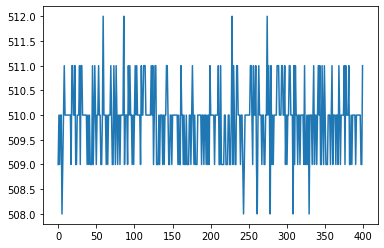

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(trace)
plt.show()